# Direct Collocation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import MX, DM, Function
import casadi as cas
from platform import python_version
from numpy.testing import assert_array_equal, assert_array_almost_equal
from lagrange_polynomial_eval import LagrangePolynomialEval

print(f"Casadi: {cas.__version__}")
print(f"Python: {python_version()}")

Casadi: 3.6.7
Python: 3.10.16


## 1. Direct Collocation

<img src="images/direct_collocation_1.png" width="50%">

### 1.1 Timing information of IPOPT with RK integrator

Note down the timing information of IPOPT: `Total CPU secs in IPOPT (w/o function
evaluations)` and `Total CPU secs in NLP function evaluations`


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3528
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     2217

Total number of variables............................:      409
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      328
Total number of inequality c

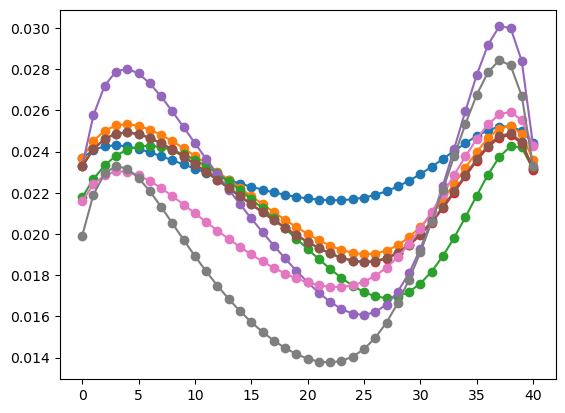

In [2]:
%run "sparse_system.py"

In [3]:
ipopt_timing_ms = {
    "Total CPU secs in IPOPT": {"rk": 160.60},
    "Total CPU secs in NLP function evaluations": {"rk": 3.98 + 1.49 + (3 + 203 + 5) / 1000}
}
ipopt_timing_ms["Total CPU secs in IPOPT (w/o function evaluations)"] = {
    "rk": (
        ipopt_timing_ms["Total CPU secs in IPOPT"]["rk"] 
        - ipopt_timing_ms["Total CPU secs in NLP function evaluations"]["rk"]
    )
}
ipopt_timing_ms

{'Total CPU secs in IPOPT': {'rk': 160.6},
 'Total CPU secs in NLP function evaluations': {'rk': 5.681},
 'Total CPU secs in IPOPT (w/o function evaluations)': {'rk': 154.91899999999998}}

### 1.2 Timing information of IPOPT with collocation integrator

Change the Runge-Kutta rk integrator to a collocation integrator. This runs a lot slower.
Can you explain?
Is the numerical result identical to the Runge-Kutta integrator?

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3528
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     2217

Total number of variables............................:      409
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      328
Total number of inequality constraints...............:      328
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      328
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1639980e-03 0.00e+00 3.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

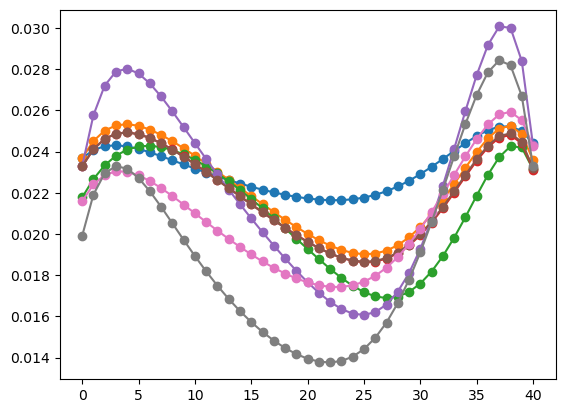

In [4]:
%run "sparse_system_1_2.py"

In [5]:
ipopt_timing_ms["Total CPU secs in IPOPT"]["collocation"] = 721.30
ipopt_timing_ms["Total CPU secs in NLP function evaluations"]["collocation"] = 20.75 + 9.79 + 3.33 + (5 + 7) / 1000
ipopt_timing_ms["Total CPU secs in IPOPT (w/o function evaluations)"]["collocation"] = (
    ipopt_timing_ms["Total CPU secs in IPOPT"]["collocation"] 
    - ipopt_timing_ms["Total CPU secs in NLP function evaluations"]["collocation"]
)
print(ipopt_timing_ms)

# Compare timing
before = ipopt_timing_ms["Total CPU secs in IPOPT"]["rk"]
after = ipopt_timing_ms["Total CPU secs in IPOPT"]["collocation"]
inc = (after - before) / before
print(f"Increase in total CPU time: {inc * 100:.0f}%")

{'Total CPU secs in IPOPT': {'rk': 160.6, 'collocation': 721.3}, 'Total CPU secs in NLP function evaluations': {'rk': 5.681, 'collocation': 33.882}, 'Total CPU secs in IPOPT (w/o function evaluations)': {'rk': 154.91899999999998, 'collocation': 687.418}}
Increase in total CPU time: 349%


Explanation:
- IPOPT with this collocation scheme is slower than with the Runge-Kutta integration scheme because it has to solve the additional rootfinding problems, which are part of the collocation method.  Thus it involves nested iterations, one iterative scheme (rootfinding) within another bigger iterative scheme.

### 1.3 Introduce extra decision variables for collocation

Introduce extra decision variables to accommodate for the helper states at the collocation points $X^c$. Do this inside the gap-closing for loop.


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9648
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     1057

Total number of variables............................:     1393
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1288
Total number of inequality constraints...............:      328
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      328
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1639980e-03 1.50e-15 3.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

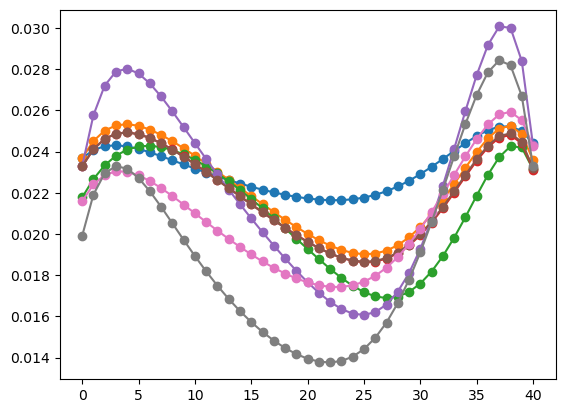

In [6]:
%run "sparse_system_1_3.py"

### 1.4 Verify that $Pi$ and therefore $\dot(Pi)$ are in fact linear in the coefficients

Open up the reference solution for task 6 of the collocation integrator exercise. We had a CasADi Function $Pi$ for the Legendre polynomial exactly interpolating through initial state $X_0$ and collocation helper states $X_c$. Use is linear to verify that $Pi$ and therefore $\dot(Pi)$ are in fact linear in the coefficients.


In [7]:
# Solution from Collocation Integrator notebook (Part 11)

# Parameters
t0 = 2
dt = 0.1
nx = 2
d = 4

# Define collocation times
tau = DM(cas.collocation_points(d, 'legendre')).T
t_coll = t0 + dt * tau
T = cas.horzcat(t0, t_coll)

# Define collocation points
X0 = MX.sym("X0", nx)
Xc = MX.sym("Xc", nx, d)
X = cas.horzcat(X0, Xc)

# Polynomial function
t = MX.sym('t')
Pi_expr = LagrangePolynomialEval(T, X, t)

# Time derivative
dPidt_expr = cas.jacobian(Pi_expr, t)

assert cas.is_linear(Pi_expr, X0) and cas.is_linear(Pi_expr, Xc)
assert cas.is_linear(dPidt_expr, X0) and cas.is_linear(dPidt_expr, Xc)


In [8]:
def make_polynomial_eval_functions(dt, nx, d, t0=0.0, scheme='legendre'):

    # Define collocation times
    tau = DM(cas.collocation_points(d, scheme)).T
    t_coll = t0 + dt * tau
    T = cas.horzcat(t0, t_coll)

    # Define collocation points
    X0 = MX.sym("X0", nx)
    Xc = MX.sym("Xc", nx, d)
    X = cas.horzcat(X0, Xc)

    # Polynomial function
    t = MX.sym('t')
    Pi_expr = LagrangePolynomialEval(T, X, t)

    # Time derivative
    dPidt_expr = cas.jacobian(Pi_expr, t)

    Pi = Function('Pi', [t, X0, Xc], [Pi_expr], ['t', 'X0', 'Xc'], ['Pi'])
    dot_Pi = Function('dot_Pi', [t, X0, Xc], [dPidt_expr], ['t', 'X0', 'Xc'], ['dPidt'])

    return Pi, dot_Pi, t_coll

# Example from Part 11
dt = 0.1
nx = 2
d = 4

Pi, dot_Pi, t_coll = make_polynomial_eval_functions(dt, nx, d)

print(Pi)
print(dot_Pi)
print(t_coll)

Pi:(t,X0[2],Xc[2x4])->(Pi[2]) MXFunction
dot_Pi:(t,X0[2],Xc[2x4])->(dPidt[2]) MXFunction
[[0.00694318, 0.0330009, 0.0669991, 0.0930568]]


### 1.5 Use linear mapping

The linear mapping can be obtained from `collocation_coeff`. Using its help, add the collocation constraints inside the multiple shooting for loop, and update the gap-closing constraint. Use a `'radau'` scheme with degree 3, which is the default for CasADi’s collocation integrator.

Verify that the solver converges to the exact same solution as in 1.2.

Compare the runtimes.

In [9]:
help(cas.collocation_coeff)

Help on function collocation_coeff in module casadi.casadi:

collocation_coeff(*args) -> 'casadi::Matrix< double > &, casadi::Matrix< double > &, casadi::Matrix< double > &'
      [INTERNAL] 
    
    ::
    
      collocation_coeff([float] tau) -> (DM OUTPUT, DM OUTPUT, DM OUTPUT)
    
    Obtain collocation interpolating matrices.
    
    A collocation method poses a polynomial Pi that interpolates exactly 
    
    through an initial state (0,X_0) and helper states at collocation 
    points 
    (tau_j,Xc_j) with j=1..degree.
    
    This function computes the linear mapping between dPi/dt and 
    coefficients 
    Z=[X_0 Xc].
    
    Parameters:
    -----------
    
    tau: 
    location of collocation points (length: degree), as obtained from 
    
    collocation_points
    
    C: 
    interpolating coefficients to obtain derivatives. Size: (degree+1)-by-
    
    degree
    
    You may find the slopes of Pi at the collocation points as
    
    ::
    
    dPi/dt @ Xc = 

In [10]:
d = 3
scheme = 'radau'

tau = cas.collocation_points(d, scheme)
C, D, B = cas.collocation_coeff(tau)
C.shape, D.shape, B.shape

((4, 3), (4, 1), (3, 1))

In [11]:
C, D, B

(DM(
 [[-4.13939, 1.73939, -3], 
  [3.22474, -3.56784, 5.53197], 
  [1.16784, 0.775255, -7.53197], 
  [-0.253197, 1.0532, 5]]),
 DM([0, 0, 0, 1]),
 DM([0.376403, 0.512486, 0.111111]))

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9648
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     1057

Total number of variables............................:     1369
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1288
Total number of inequality constraints...............:      328
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      328
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1639980e-03 6.99e-15 3.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

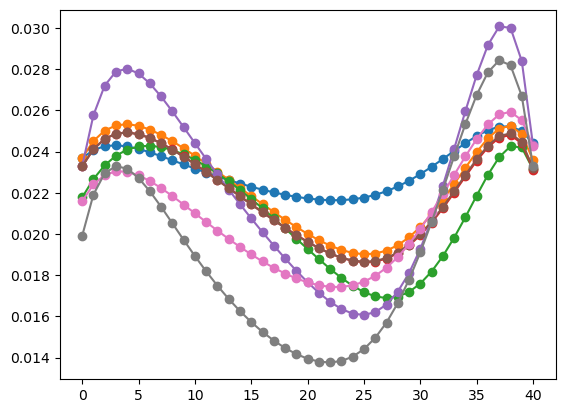

In [12]:
%run "sparse_system_1_5.py"

In [13]:
ipopt_timing_ms["Total CPU secs in IPOPT"]["collocation2"] = 244.09
ipopt_timing_ms["Total CPU secs in NLP function evaluations"]["collocation2"] = 21.38 + 3.34 + 2.55 + (83 + 259) / 1000
ipopt_timing_ms["Total CPU secs in IPOPT (w/o function evaluations)"]["collocation2"] = (
    ipopt_timing_ms["Total CPU secs in IPOPT"]["collocation2"] 
    - ipopt_timing_ms["Total CPU secs in NLP function evaluations"]["collocation2"]
)
print(ipopt_timing_ms)

# Compare timing
before = ipopt_timing_ms["Total CPU secs in IPOPT"]["rk"]
after = ipopt_timing_ms["Total CPU secs in IPOPT"]["collocation2"]
inc = (after - before) / before
print(f"Increase in total CPU time: {inc * 100:.0f}%")

{'Total CPU secs in IPOPT': {'rk': 160.6, 'collocation': 721.3, 'collocation2': 244.09}, 'Total CPU secs in NLP function evaluations': {'rk': 5.681, 'collocation': 33.882, 'collocation2': 27.612}, 'Total CPU secs in IPOPT (w/o function evaluations)': {'rk': 154.91899999999998, 'collocation': 687.418, 'collocation2': 216.478}}
Increase in total CPU time: 52%
